# data_feature_engineering4

2017-05-31

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime,timedelta,date,time
import matplotlib.pyplot as plt
%matplotlib inline
import copy

### 录入数据

In [2]:
travel_time_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/train_20min_avg_travel_time.csv')
volume_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/train_20min_avg_volume.csv')
weather_data = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/原始数据/weather_train.csv')

test_travel_time_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/test_20min_avg_travel_time.csv')
test_volume_window = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/时间窗数据/test_20min_avg_volume.csv')
test_weather_data = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_data/原始数据/weather_test.csv')

### 补充特征

In [3]:
# 整合平均时间与天气数据
travel_time_window['start_time'] = travel_time_window['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
weather_data['date'] = weather_data['date'].astype(str)
weather_data['hour'] = weather_data['hour'].map(lambda x: ' ' + time(x, 0, 0).strftime('%H:%M:%S'))
weather_data['start_time'] = weather_data['date'] + weather_data['hour']
weather_data['start_time'] = weather_data['start_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
del weather_data['date']
del weather_data['hour']
num = len(weather_data)
for i in range(num):
    temp = weather_data.ix[i]
    temp1 = copy.deepcopy(temp)
    temp2 = copy.deepcopy(temp)
    temp3 = copy.deepcopy(temp)
    temp4 = copy.deepcopy(temp)
    temp5 = copy.deepcopy(temp)
    temp6 = copy.deepcopy(temp)
    temp7 = copy.deepcopy(temp)
    temp8 = copy.deepcopy(temp)
    stime = temp.start_time
    temp1.start_time = stime + timedelta(minutes=20)
    temp2.start_time = stime + timedelta(minutes=40)
    temp3.start_time = stime + timedelta(minutes=60)
    temp4.start_time = stime + timedelta(minutes=80)
    temp5.start_time = stime + timedelta(minutes=100)
    temp6.start_time = stime + timedelta(minutes=120)
    temp7.start_time = stime + timedelta(minutes=140)
    temp8.start_time = stime + timedelta(minutes=160)
    alltemp = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
    alltemp = pd.DataFrame(alltemp)
    weather_data = pd.concat([weather_data, alltemp])
# 合并
travel_time_window = pd.merge(travel_time_window, weather_data, on='start_time', how='left')
travel_time_window['time'] = travel_time_window['start_time'].map(lambda x: x.time())
travel_time_window['date'] = travel_time_window['start_time'].map(lambda x: x.date())

# 整合流量与天气数据
volume_window['start_time'] = volume_window['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:],'%Y-%m-%d %H:%M:%S'))
volume_window['pair'] = volume_window['tollgate_id'].astype(str) + '-' + volume_window['direction'].astype(str)
volume_window = pd.merge(volume_window, weather_data, on='start_time', how='left')

In [4]:
# 增加路线和星期几，小时，分钟
travel_time_window['weekday'] = travel_time_window['start_time'].map(lambda x: x.weekday())
travel_time_window['hour'] = travel_time_window['start_time'].map(lambda x: x.hour)
travel_time_window['minute'] = travel_time_window['start_time'].map(lambda x: x.minute)
travel_time_window['route'] = travel_time_window['intersection_id'].astype(str) + '-' + travel_time_window['tollgate_id'].astype(str)

# 增加星期几和时间窗口两列
volume_window['date'] = volume_window['start_time'].map(lambda x: x.date())
volume_window['weekday'] = volume_window['start_time'].map(lambda x: x.weekday())
volume_window['time'] = volume_window['start_time'].map(lambda x: x.time())
volume_window['hour'] = volume_window['start_time'].map(lambda x: x.hour)
volume_window['minute'] = volume_window['start_time'].map(lambda x: x.minute)

In [5]:
# 增加月份和几号
travel_time_window['month'] = travel_time_window['date'].map(lambda x: x.month)
travel_time_window['day'] = travel_time_window['date'].map(lambda x: x.day)

volume_window['month'] = volume_window['date'].map(lambda x: x.month)
volume_window['day'] = volume_window['date'].map(lambda x: x.day)

In [6]:
# 把time映射成1～72
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
travel_time_window['timemap'] = travel_time_window['time'].map(lambda x:timedic[x])

# 时间映射成1～72
volume_window['timemap'] = volume_window['time'].map(lambda x:timedic[x])

In [7]:
# 增加法定节假日特征
#holiday = ['2016-09-15','2016-09-16','2016-09-17','2016-10-01','2016-10-02','2016-10-03','2016-10-04','2016-10-05','2016-10-06','2016-10-07']
holiday = [date(2016,9,15),date(2016,9,16),date(2016,9,17),date(2016,10,1),date(2016,10,2),date(2016,10,3),date(2016,10,4),date(2016,10,5),date(2016,10,6),date(2016,10,7)]

def ff(x):
    if x in holiday:
        return 1
    else:
        return 0
travel_time_window['holiday'] = travel_time_window['date'].map(ff)

volume_window['holiday'] = volume_window['date'].map(ff)

### 排序

In [8]:
time_columns = ['avg_travel_time', 
                'route', 'intersection_id', 'tollgate_id', 
                'time_window', 'start_time', 
                'date', 'month', 'day', 'weekday', 'holiday',
                'time', 'hour', 'minute', 'timemap',
                'pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 
                 ]

volume_columns = ['volume',
                  'pair', 'tollgate_id', 'direction',
                  'time_window', 'start_time',
                  'date', 'month', 'day', 'weekday', 'holiday',
                  'time', 'hour', 'minute', 'timemap',
                  'pressure', 'sea_pressure', 'wind_direction', 'wind_speed', 'temperature', 'rel_humidity', 'precipitation', 
                  ]

travel_time_window = travel_time_window[time_columns]
volume_window = volume_window[volume_columns]

travel_time_window = travel_time_window.sort_values(by=['route', 'start_time'])
travel_time_window.index = np.arange(len(travel_time_window))

volume_window = volume_window.sort_values(by=['pair', 'start_time'])
volume_window.index = np.arange(len(volume_window))

### 清洗数据

In [9]:
# 风向异常值处理，以最近的风向值代替
wind_direction = travel_time_window['wind_direction']
wind_direction[wind_direction > 360] = np.nan
wind_direction.fillna(method='ffill', inplace=True)

wind_direction = volume_window['wind_direction']
wind_direction[wind_direction > 360] = np.nan
wind_direction.fillna(method='ffill', inplace=True)

/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# 流量节假日数据清除
volume_window = volume_window[volume_window['holiday'] == 0]

### 排序观察大致走势

In [11]:
travel_time_window = travel_time_window.sort_values(by=['route', 'start_time'])
travel_time_window.index = np.arange(len(travel_time_window))

volume_window = volume_window.sort_values(by=['pair', 'start_time'])
volume_window.index = np.arange(len(volume_window))

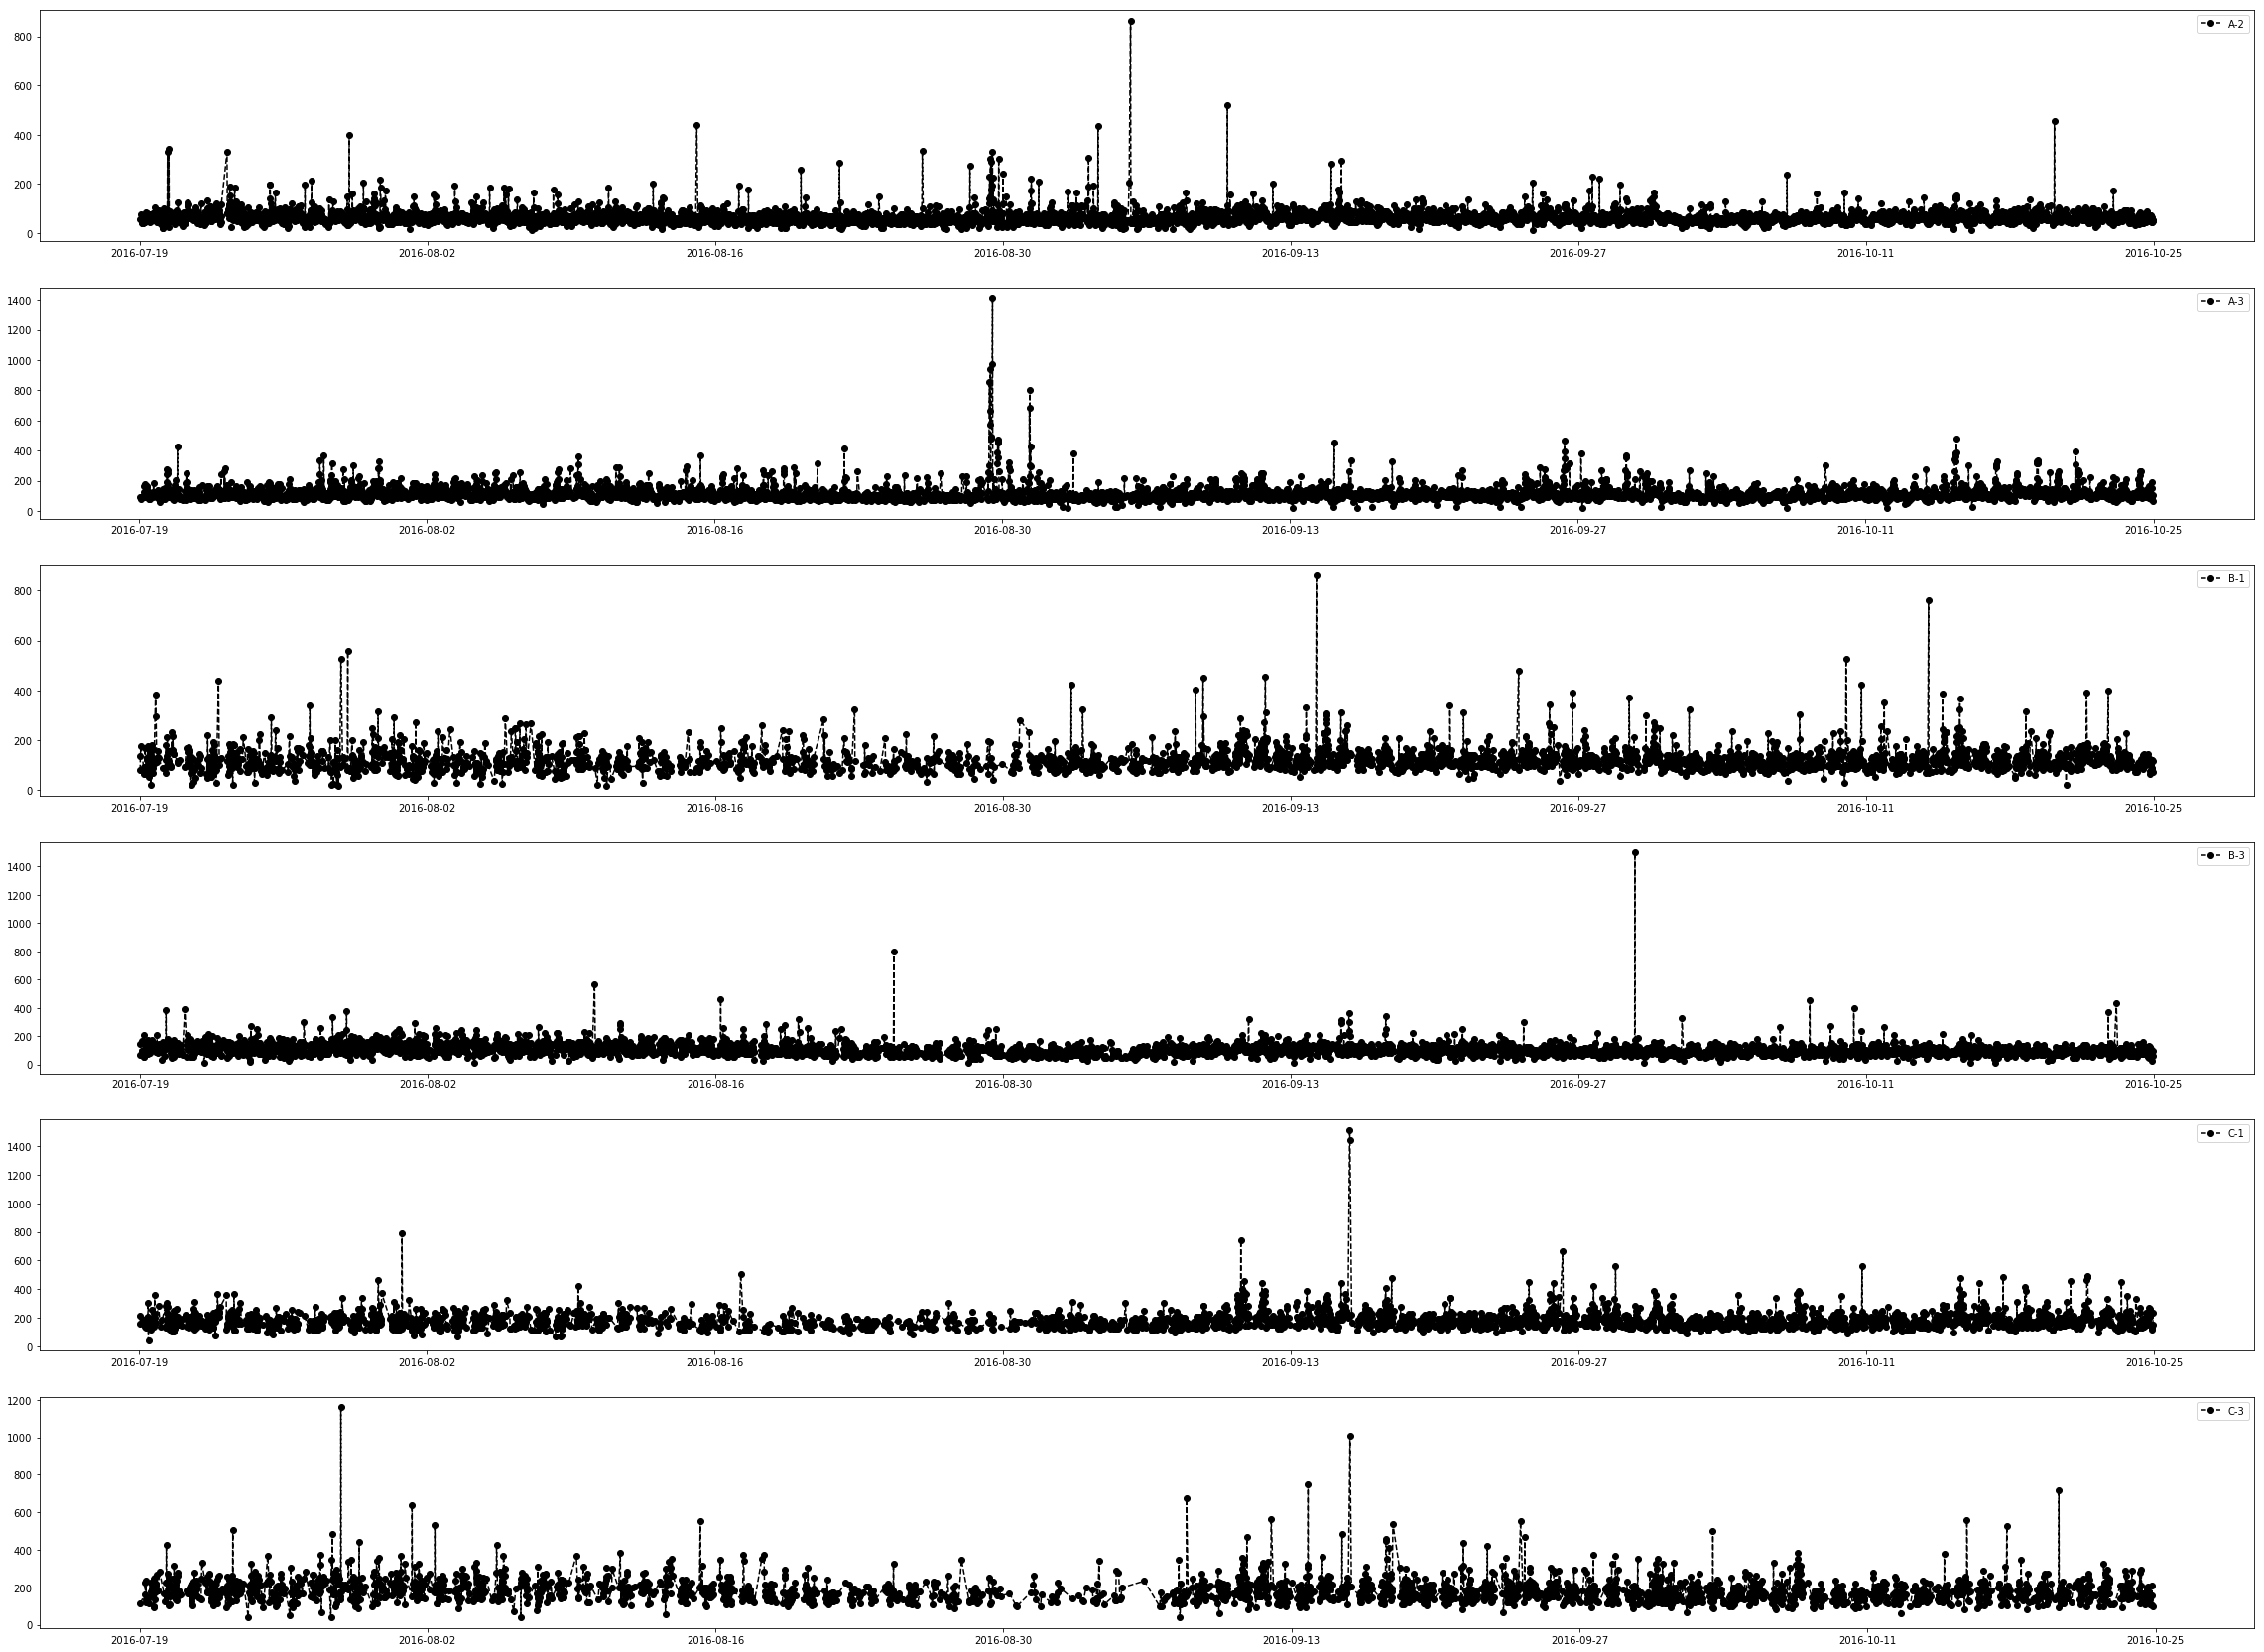

In [12]:
grouped_by_route = travel_time_window.groupby(['route'])
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(40)
k = 1
for k1, group in grouped_by_route:  
    ax = fig.add_subplot(6,1,k)
    k += 1
    ax.plot(group['start_time'], group['avg_travel_time'],'ko--', label=k1)
    ax.legend()

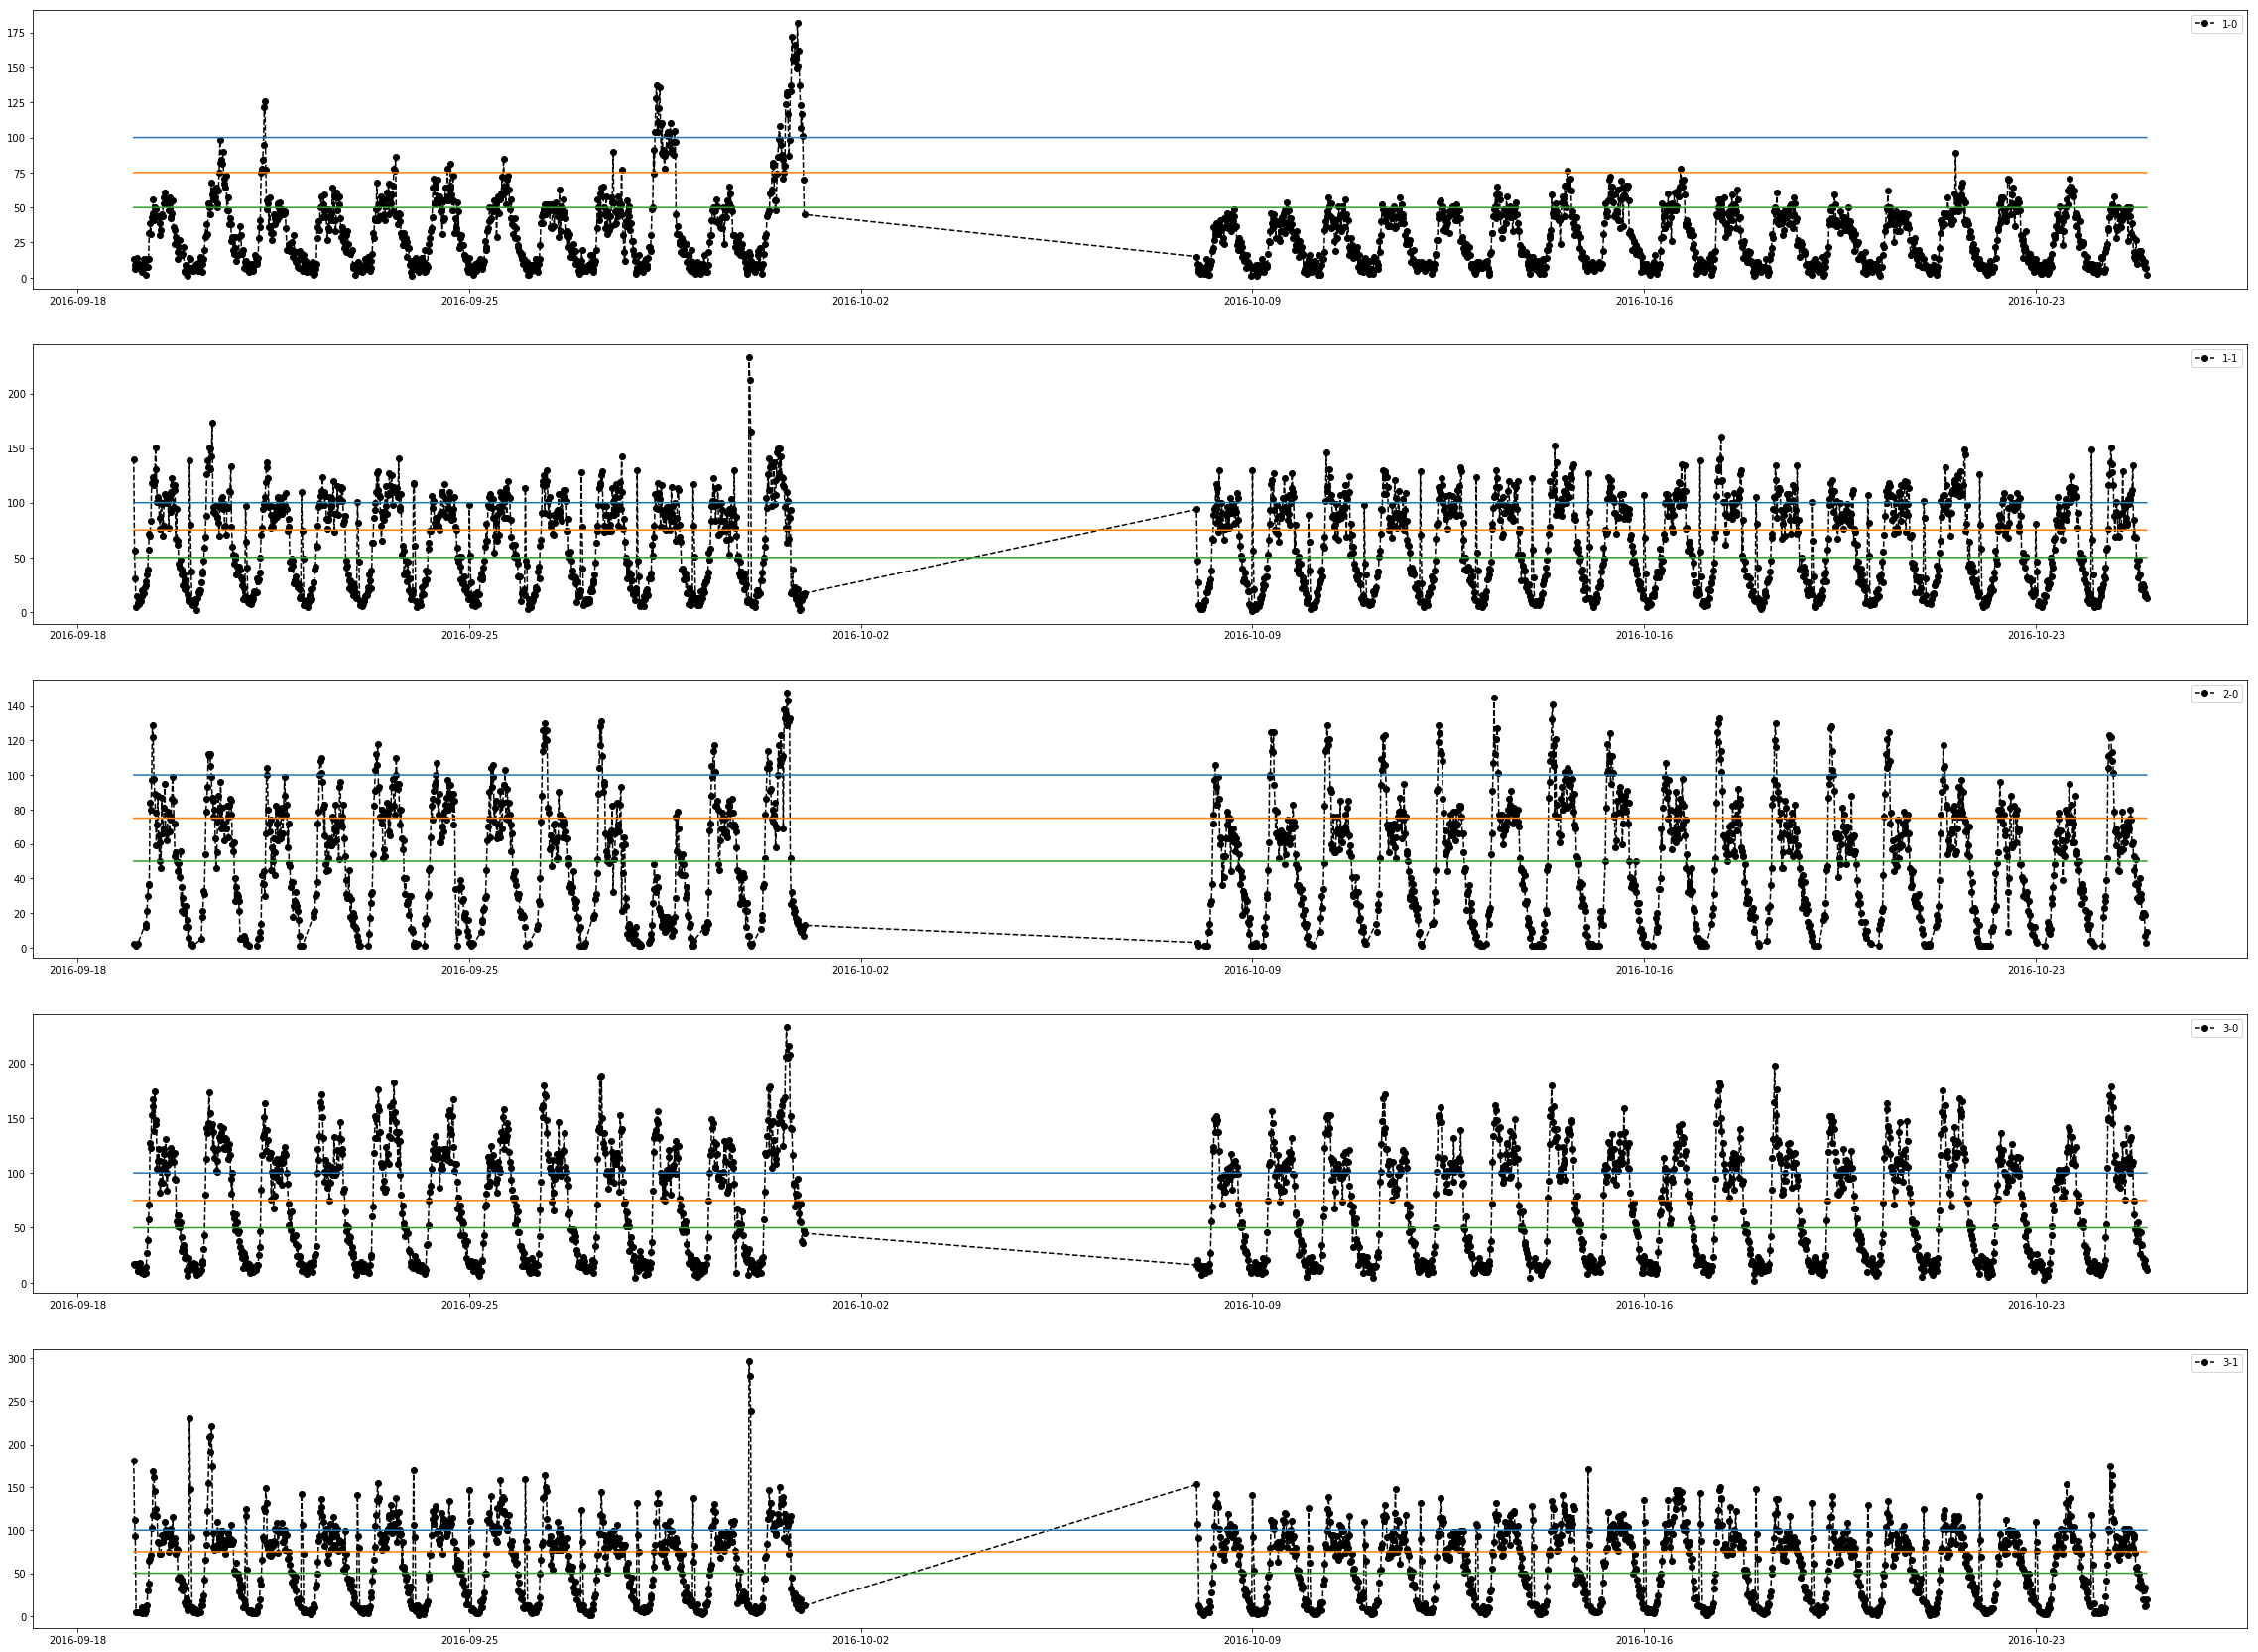

In [13]:
grouped_by_pair = volume_window.groupby(['pair'])
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(40)
k = 1
for k1, group in grouped_by_pair:  
    ax = fig.add_subplot(5,1,k)
    k += 1
    ax.plot(group['start_time'], group['volume'],'ko--', label=k1)
    ax.plot(group['start_time'], 100*np.ones(len(group)))
    ax.plot(group['start_time'], 75*np.ones(len(group)))
    ax.plot(group['start_time'], 50*np.ones(len(group)))
    ax.legend()

### 分割，只留9.19之后的数据

In [14]:
# 只取9.19之后的数据
start_date = date(2016,9,19)
travel_time_window = travel_time_window[travel_time_window['date'] >= start_date]

### 补充测试集特征

In [15]:
# 天气特征
test_weather_data['hour'] = test_weather_data['hour'].map(lambda x: ' ' + time(x, 0, 0).strftime('%H:%M:%S'))
test_weather_data['start_time'] = test_weather_data['date'] + test_weather_data['hour']
test_weather_data['start_time'] = test_weather_data['start_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
del test_weather_data['date']
del test_weather_data['hour']
num = len(test_weather_data)
for i in range(num):
    temp = test_weather_data.ix[i]
    temp1 = copy.deepcopy(temp)
    temp2 = copy.deepcopy(temp)
    temp3 = copy.deepcopy(temp)
    temp4 = copy.deepcopy(temp)
    temp5 = copy.deepcopy(temp)
    temp6 = copy.deepcopy(temp)
    temp7 = copy.deepcopy(temp)
    temp8 = copy.deepcopy(temp)
    stime = temp.start_time
    temp1.start_time = stime + timedelta(minutes=20)
    temp2.start_time = stime + timedelta(minutes=40)
    temp3.start_time = stime + timedelta(minutes=60)
    temp4.start_time = stime + timedelta(minutes=80)
    temp5.start_time = stime + timedelta(minutes=100)
    temp6.start_time = stime + timedelta(minutes=120)
    temp7.start_time = stime + timedelta(minutes=140)
    temp8.start_time = stime + timedelta(minutes=160)
    alltemp = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
    alltemp = pd.DataFrame(alltemp)
    test_weather_data = pd.concat([test_weather_data, alltemp])

In [17]:
# 测试集均值补充
submission_travel_time = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_submission/day1/travel_time_submission.csv')
submission_volume = pd.read_csv('/home/godcedric/GitLocal/KDDCUP2017/final_submission/day1/volume_submission.csv')

In [19]:
# 补充
submission_travel_time['start_time'] = submission_travel_time['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
submission_travel_time['weekday'] = submission_travel_time['start_time'].map(lambda x: x.weekday())
submission_travel_time = submission_travel_time.sort_values(by=['intersection_id','tollgate_id','weekday','start_time'])
submission_travel_time.index = np.arange(len(submission_travel_time))

In [24]:
# 补充
submission_volume['start_time'] = submission_volume['time_window'].map(lambda x: datetime.strptime(x.split(',')[0][1:], '%Y-%m-%d %H:%M:%S'))
submission_volume['weekday'] = submission_volume['start_time'].map(lambda x: x.weekday())
submission_volume = submission_volume.sort_values(by=['tollgate_id','direction','weekday','start_time'])
submission_volume.index = np.arange(len(submission_volume))

In [20]:
submission_travel_time = submission_travel_time.sort_values(by = ['intersection_id', 'tollgate_id', 'start_time'])
submission_travel_time.index = np.arange(len(submission_travel_time))

submission_travel_time = pd.merge(submission_travel_time, test_weather_data, on='start_time', how='left')
submission_travel_time['date'] = submission_travel_time['start_time'].map(lambda x: x.date())
submission_travel_time['time'] = submission_travel_time['start_time'].map(lambda x: x.time())
submission_travel_time['hour'] = submission_travel_time['start_time'].map(lambda x: x.hour)
submission_travel_time['minute'] = submission_travel_time['start_time'].map(lambda x: x.minute)

In [21]:
# weekday特征
submission_travel_time['weekday'] = submission_travel_time['start_time'].map(lambda x: x.weekday())
# route特征
submission_travel_time['route'] = submission_travel_time['intersection_id'].astype(str) + '-' + submission_travel_time['tollgate_id'].astype(str)

In [22]:
# 把time映射成1～72
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
submission_travel_time['timemap'] = submission_travel_time['time'].map(lambda x:timedic[x])

In [25]:
submission_volume = submission_volume.sort(['tollgate_id', 'direction', 'start_time'])
# pair特征
submission_volume['pair'] = submission_volume['tollgate_id'].astype(str) + '-' + submission_volume['direction'].astype(str)

# 天气特征
submission_volume = pd.merge(submission_volume, test_weather_data, on='start_time', how='left')

# 星期几
submission_volume['weekday'] = submission_volume['start_time'].map(lambda x: x.weekday())

# 时间窗口
submission_volume['time'] = submission_volume['start_time'].map(lambda x: x.time())
submission_volume['date'] = submission_volume['start_time'].map(lambda x: x.date())

submission_volume['hour'] = submission_volume['start_time'].map(lambda x: x.hour)
submission_volume['minute'] = submission_volume['start_time'].map(lambda x: x.minute)

/home/godcedric/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [29]:
from collections import defaultdict
time_start = datetime(2016,10,17,0,0,0)
timedic = defaultdict(int)
for i in range(72):
    timedic[time_start.time()] = i+1
    time_start = time_start + timedelta(minutes=20)
submission_volume['timemap'] = submission_volume['time'].map(lambda x:timedic[x])

### 选择特征输出

In [30]:
submission_travel_time['month'] = submission_travel_time['date'].map(lambda x: x.month)
submission_travel_time['day'] = submission_travel_time['date'].map(lambda x: x.day)
submission_travel_time['holiday'] = 0

submission_volume['month'] = submission_volume['date'].map(lambda x: x.month)
submission_volume['day'] = submission_volume['date'].map(lambda x: x.day)
submission_volume['holiday'] = 0

In [31]:
time_columns = ['route', 'intersection_id', 'tollgate_id',
                'time_window', 'start_time', 'date', 'month', 'day', 'weekday',
                'holiday', 'time', 'hour', 'minute', 'timemap', 'pressure',
                'sea_pressure', 'wind_direction', 'wind_speed', 'temperature',
                'rel_humidity', 'precipitation']
volume_columns = ['pair', 'tollgate_id', 'direction', 'time_window',
                  'start_time', 'date', 'month', 'day', 'weekday', 'holiday', 'time',
                  'hour', 'minute', 'timemap', 'pressure', 'sea_pressure',
                  'wind_direction', 'wind_speed', 'temperature', 'rel_humidity',
                  'precipitation']

In [32]:
submission_travel_time = submission_travel_time[time_columns]
submission_volume = submission_volume[volume_columns]